## Demo for Loading and Combining TDC Data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.TDI import *


# or just
# from Triangle import *

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

/Users/taijidatacenter/miniconda3/envs/triangle/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load data to directionary 
All the TDC data can be loaded as dictionaries, each containing 3 items: 
- ``eta``: the single-link measurements $\eta_{ij}$ (intermediate variable of TDI processing), which is a dictionary with keys "12", "23", "31", "21", "32", "13"; 
- ``time``: the time of data; 
- ``parameters``: the parameters of GW sources. 

The default unit of data is fractional frequency difference (dimensionless).

In [ ]:
# h2filename should be the path of TDC data
h5filename = "/Volumes/RubbishBin/TDC2_GWData/5_h5datasets/singlemultiplesource_dataset_mbhb_30dayfrom10day.h5"
with h5py.File(h5filename, "r") as h5file: 
    data_dict = read_dict_from_h5(h5file["/"])
data_dict

{'eta': {'12': array([0., 0., 0., ..., 0., 0., 0.]),
  '13': array([ 0., -0., -0., ...,  0.,  0.,  0.]),
  '21': array([0., 0., 0., ..., 0., 0., 0.]),
  '23': array([0., 0., 0., ..., 0., 0., 0.]),
  '31': array([ 0.,  0., -0., ...,  0.,  0.,  0.]),
  '32': array([0., 0., 0., ..., 0., 0., 0.])},
 'parameters': {'chirp_mass': 100000.0,
  'coalescence_phase': 1.3175247453756198,
  'coalescence_time': 35,
  'inclination': 1.354709797095615,
  'latitude': 0.8897173002134268,
  'longitude': 5.040783166599757,
  'luminosity_distance': 12920.857145085234,
  'mass_ratio': 0.16276683405144093,
  'polarization': 1.1180387695121354,
  'spin_1z': -0.0002285110554551828,
  'spin_2z': -0.39522791112696587},
 'time': array([ 864000.,  864001.,  864002., ..., 3455997., 3455998., 3455999.])}

### Visualize raw data 
The single-link measurements are dominated by laser frequency noises, which needs to be suppressed by the subsequent TDI processing. 

Text(0, 0.5, '$\\eta_{12}$')

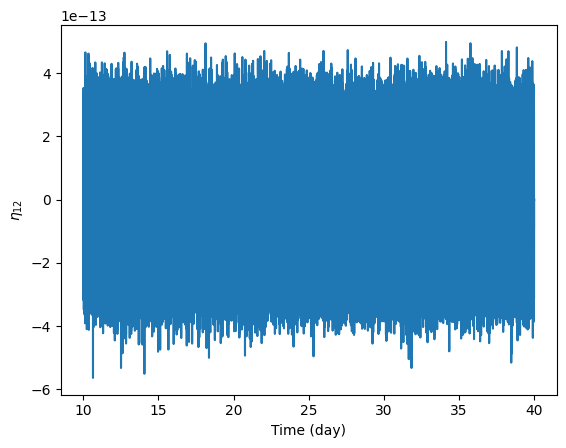

In [11]:
plt.plot(data_dict["time"] / DAY, data_dict["eta"]["12"])
plt.xlabel("Time (day)")
plt.ylabel(r"$\eta_{12}$")

Text(0, 0.5, '$\\tilde{\\eta}_{12}$')

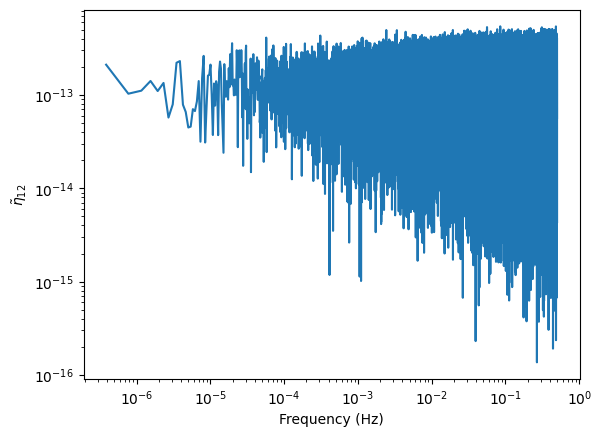

In [12]:
fsample = 1. / (data_dict["time"][1] - data_dict["time"][0])
ff, xf = PSD_window(data_dict["eta"]["12"], fsample=fsample, nbin=1, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.sqrt(xf))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{\eta}_{12}$")

### TDI combination 
To explore the impacts and effects of various TDI schemes in GW data analysis, all the TDC data are provided in terms of single-link measurement $\eta_{ij}$.
Since we start from $\eta_{ij}$, the first 2 steps of TDI (raw data $\rightarrow \xi_{ij}, \xi_{ij} \rightarrow \eta_{ij}$) are unnecessary.
The users only need to combine their custom TDI channels according to the methods outlined in Demo 1 and Demo 2. 
In this demo, we employ the ``FastMichelson`` method as an example.

In [13]:
# calculate the light travel times, which will be used as the delays
orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB')
ltts = dict() 
for key in MOSA_labels: 
    ltts[key] = orbit.LTTfunctions()[key](data_dict["time"])
ltts = MOSADict(ltts)

# prepare the input data 
m = {"eta" : data_dict["eta"]}

# initical TDI object. We recommand a high interpolation order of 31 to effectively suppress laser frequency noise
tdi = TDI(measurements=m, delays=ltts, fsample=fsample, order=31) 

# TDI combination 
tdi.FastMichelson(channel="X")

### Visualize TDI data 

Text(0, 0.5, 'Data before and after TDI')

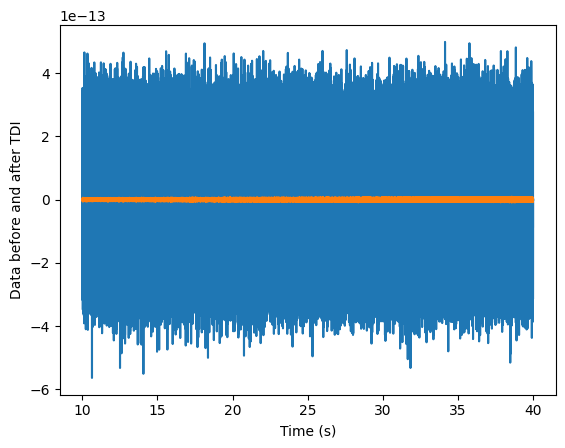

In [22]:
plt.plot(data_dict["time"] / DAY, data_dict["eta"]["12"])
plt.plot(data_dict["time"][1500:-1500] / DAY, tdi.measurements["X2"][1500:-1500]) # we drop 1500 seconds at the edges 
plt.xlabel("Time (s)")
plt.ylabel("Data before and after TDI")

When plotted in the frequency domain, it is evident that a MBHB signal exceeds the noise floor in the mHz to 10mHz band. To clearly show the waveform in the time domain, a further downsampling process (e.g. fsample = 1 Hz to fsample = 0.1 Hz) is required.

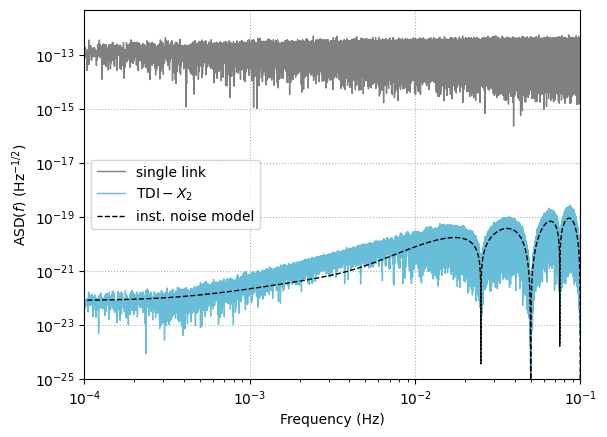

In [24]:
ff, xf = PSD_window(data_dict["eta"]["12"], fsample, 1, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.sqrt(xf), color="grey", linewidth=1, label="single link")

ff, xf = PSD_window(tdi.measurements["X2"][1500:-1500], fsample, 1, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.sqrt(xf), color=BLUE, linewidth=1, label=r"${\rm TDI-}X_2$")

PSD = TDIPSDs()
plt.loglog(ff, np.sqrt(PSD.PSD_X2(ff)), color="k", linewidth=1, linestyle="--", label="inst. noise model")

plt.xlim(1e-4, 0.1)
plt.ylim(1e-25, )
plt.grid(linestyle=":")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"${\rm ASD}(f) \ ({\rm Hz^{-1/2}})$")
plt.legend(loc="center left")

Text(0, 0.5, 'TDI-X2')

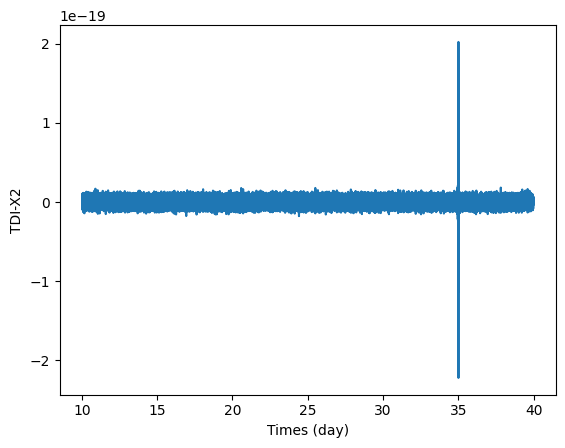

In [25]:
x2_ds = downsampling(tdi.measurements["X2"][1500:-1500], fsample, 10, [240, 0.02, 0.08])[100:-100]
time_ds = ((data_dict["time"][1500:-1500])[::10])[100:-100]
plt.plot(time_ds / DAY, x2_ds)
plt.xlabel("Times (day)")
plt.ylabel("TDI-X2")